<a href="https://colab.research.google.com/github/takashi4488/rabbit_challenge/blob/main/Day3_%E3%83%AC%E3%83%9D%E3%83%BC%E3%83%88_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 準備

## Google Colab 用の処理

下記を実行します
- ドライブのマウント
- ノートブックファイルと同じフォルダへの移動

Googleドライブのマイドライブ を基準に DNN_code/DNN_code_colab_day3 フォルダを置くことを仮定しています。必要に応じて，パスを変更してください．

In [1]:
# Google Colab での実行かを調べる
import sys
import os
ENV_COLAB = True  if 'google.colab' in sys.modules else False

# google drive のマウント
if ENV_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/ML-E検定/DNN_code_colab_day3_ver2/DNN_code_colab_day3_ver2/notebook')

Mounted at /content/drive


## sys.pathの設定

In [2]:
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定


# Section1 RNN

/tmp/ipython-input-2448858310.py:93: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  out_bin[-t-1] = np.round(y[:, t])


Iteration: 0, Loss: 1.1412
Iteration: 1000, Loss: 1.0163
Iteration: 2000, Loss: 0.8544
Iteration: 3000, Loss: 0.7841
Iteration: 4000, Loss: 0.4350
Iteration: 5000, Loss: 0.2098
Iteration: 6000, Loss: 0.2544
Iteration: 7000, Loss: 0.0336
Iteration: 8000, Loss: 0.0355
Iteration: 9000, Loss: 0.0236


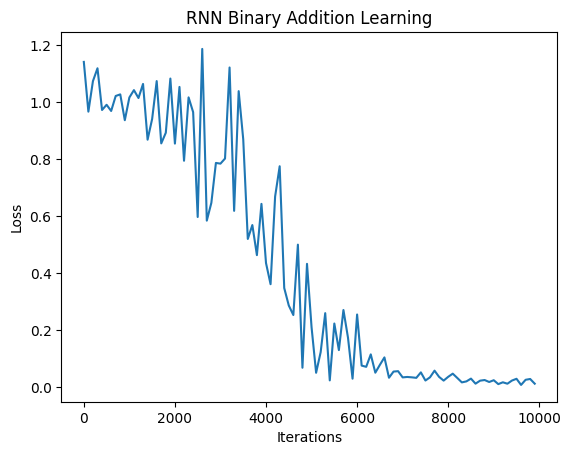

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# --- 必要な関数の定義 (common.functionsの代わり) ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def d_sigmoid(x):
    # シグモイド関数の微分 (出力値を用いた簡略版)
    # 本来は sigmoid(x)*(1-sigmoid(x)) ですが、
    # このコードの構成に合わせて調整します
    return x * (1 - x)

def mean_squared_error(d, y):
    return 0.5 * np.sum((d - y)**2)

def d_mean_squared_error(d, y):
    return y - d

def d_tanh(x):
    return 1 / (np.cosh(x) ** 2)

# --- データの準備 ---
binary_dim = 8
largest_number = pow(2, binary_dim)
# binary tableの作成
binary = np.unpackbits(np.array([range(largest_number)], dtype=np.uint8).T, axis=1)

# --- ハイパーパラメータ ---
input_layer_size = 2
hidden_layer_size = 16
output_layer_size = 1
weight_init_std = 1
learning_rate = 0.1
iters_num = 10000
plot_interval = 100

# --- ウェイト初期化 ---
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配初期化
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

all_losses = []

# --- 学習ループ ---
for i in range(iters_num):

    # A, B 初期化 (a + b = d)
    a_int = np.random.randint(largest_number/2)
    a_bin = binary[a_int]
    b_int = np.random.randint(largest_number/2)
    b_bin = binary[b_int]

    # 正解データ
    d_int = a_int + b_int
    d_bin = binary[d_int]

    out_bin = np.zeros_like(d_bin)
    all_loss = 0

    # 時系列ごとの保存用変数
    u = np.zeros((hidden_layer_size, binary_dim + 1))
    z = np.zeros((hidden_layer_size, binary_dim + 1))
    y = np.zeros((output_layer_size, binary_dim))
    delta_out = np.zeros((output_layer_size, binary_dim))
    delta = np.zeros((hidden_layer_size, binary_dim + 1))

    # --- 順伝播 (Forward) ---
    for t in range(binary_dim):
        # 1の位から計算するため後ろから取り出す
        X = np.array([a_bin[-t-1], b_bin[-t-1]]).reshape(1, -1)
        dd = np.array([d_bin[-t-1]])

        # 隠れ層の計算
        u[:, t+1] = np.dot(X, W_in) + np.dot(z[:, t], W)
        z[:, t+1] = sigmoid(u[:, t+1])

        # 出力層の計算
        y[:, t] = sigmoid(np.dot(z[:, t+1], W_out))

        # 誤差
        loss = mean_squared_error(dd, y[:, t])
        all_loss += loss

        # 出力層のデルタ (MSE微分 * sigmoid微分)
        delta_out[:, t] = d_mean_squared_error(dd, y[:, t]) * d_sigmoid(y[:, t])

        out_bin[-t-1] = np.round(y[:, t])

    # --- 逆伝播 (Backward) ---
    for t in range(binary_dim)[::-1]:
        X = np.array([a_bin[-t-1], b_bin[-t-1]]).reshape(1, -1)

        # 隠れ層のデルタ (BPTT)
        # 次の時刻のデルタと現在の出力層のデルタを合算
        delta[:, t] = (np.dot(W, delta[:, t+1]) + np.dot(W_out, delta_out[:, t])) * d_sigmoid(z[:, t+1])

        # 勾配の蓄積
        W_out_grad += np.dot(z[:, t+1].reshape(-1, 1), delta_out[:, t].reshape(1, -1))
        W_grad += np.dot(z[:, t].reshape(-1, 1), delta[:, t].reshape(1, -1))
        W_in_grad += np.dot(X.T, delta[:, t].reshape(1, -1))

    # --- 重みの更新 ---
    W_in -= learning_rate * W_in_grad
    W_out -= learning_rate * W_out_grad
    W -= learning_rate * W_grad

    # 勾配リセット
    W_in_grad *= 0
    W_out_grad *= 0
    W_grad *= 0

    if (i % plot_interval == 0):
        all_losses.append(all_loss)
        if i % 1000 == 0:
            print(f"Iteration: {i}, Loss: {all_loss:.4f}")

# --- 結果の可視化 ---
plt.plot(range(0, iters_num, plot_interval), all_losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('RNN Binary Addition Learning')
plt.show()

# Section2 LSTM

In [4]:
import numpy as np

# 1. 必要な活性化関数の定義
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 2. GRU関数の修正
def gru(x, h, W_r, U_r, W_z, U_z, W, U):
    """
    x: 入力ベクトル (1, input_dim)
    h: 前の時刻の隠れ状態 (1, hidden_dim)
    """
    # リセットゲート: 過去の情報をどれくらい捨てるか
    r = _sigmoid(x.dot(W_r.T) + h.dot(U_r.T))

    # 更新ゲート: 過去の情報をどれくらい次に引き継ぐか
    z = _sigmoid(x.dot(W_z.T) + h.dot(U_z.T))

    # 次の状態の候補 (h_bar)
    # リセットゲート r を使って過去の隠れ状態 h を制御
    h_bar = np.tanh(x.dot(W.T) + (r * h).dot(U.T))

    # 次の隠れ状態 h_new
    # 更新ゲート z に基づいて、過去の h と新しい候補 h_bar を混合
    h_new = (1 - z) * h + z * h_bar

    return h_new

# --- 動作確認用のテストコード ---

# パラメータ設定
input_dim = 3
hidden_dim = 2

# 重みの初期化 (ランダム)
W_r = np.random.randn(hidden_dim, input_dim)
U_r = np.random.randn(hidden_dim, hidden_dim)
W_z = np.random.randn(hidden_dim, input_dim)
U_z = np.random.randn(hidden_dim, hidden_dim)
W = np.random.randn(hidden_dim, input_dim)
U = np.random.randn(hidden_dim, hidden_dim)

# 入力データと初期隠れ状態
x_test = np.random.randn(1, input_dim)
h_test = np.zeros((1, hidden_dim))

# 実行
h_next = gru(x_test, h_test, W_r, U_r, W_z, U_z, W, U)

print("入力 x:\n", x_test)
print("計算された次の隠れ状態 h_new:\n", h_next)

入力 x:
 [[-0.48575849 -0.09451273 -1.74814119]]
計算された次の隠れ状態 h_new:
 [[-0.04491443 -0.08410554]]


# Section3 GRU

In [5]:
import numpy as np

# 1. 必要な活性化関数の定義
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

# 2. GRU関数の修正
def gru(x, h, W_r, U_r, W_z, U_z, W, U):
    """
    x: 現在の入力 (batch_size, input_dim)
    h: 前の時刻の隠れ状態 (batch_size, hidden_dim)
    W_*: 入力に対する重み
    U_*: 隠れ状態に対する重み
    """
    # リセットゲート: 過去の情報をどれくらい無視するかを決定
    r = _sigmoid(x.dot(W_r.T) + h.dot(U_r.T))

    # 更新ゲート: 過去の状態と新しい状態をどれくらいの比率で混ぜるか
    z = _sigmoid(x.dot(W_z.T) + h.dot(U_z.T))

    # 現在の入力とリセットされた過去の情報から「新しい情報の候補」を作成
    # (r * h) によって、過去の情報を取捨選択している
    h_bar = np.tanh(x.dot(W.T) + (r * h).dot(U.T))

    # 最終的な隠れ状態の更新
    # zが1に近いほど新しい情報(h_bar)を重視し、0に近いほど過去(h)を保持する
    h_new = (1 - z) * h + z * h_bar

    return h_new

# --- 動作確認用セットアップ ---

# ハイパーパラメータ
input_dim = 3
hidden_dim = 4

# 重みの初期化 (標準正規分布)
W_r, U_r = np.random.randn(hidden_dim, input_dim), np.random.randn(hidden_dim, hidden_dim)
W_z, U_z = np.random.randn(hidden_dim, input_dim), np.random.randn(hidden_dim, hidden_dim)
W, U = np.random.randn(hidden_dim, input_dim), np.random.randn(hidden_dim, hidden_dim)

# テスト入力 (batch_size=1)
x_test = np.random.randn(1, input_dim)
h_prev = np.zeros((1, hidden_dim))

# 実行
h_next = gru(x_test, h_prev, W_r, U_r, W_z, U_z, W, U)

print("Next Hidden State:")
print(h_next)

Next Hidden State:
[[-0.3895835   0.45277759  0.53314344  0.30395422]]


# Section4 双方向RNN

In [6]:
import numpy as np

# 活性化関数の定義
def _sigmoid(x):
    return 1 / (1 + np.exp(-x))

# RNNの順伝播処理を定義
def _rnn(xs, W, U):
    # xs: (時間サイズ, 入力次元)
    # h: 隠れ層の初期状態
    h = np.zeros((1, W.shape[0])) # 隠れ層の初期化
    hs = []

    for x in xs:
        # 入力を2次元 (1, input_dim) に調整
        x = x.reshape(1, -1)
        # 隠れ層の更新: h = sigmoid(x*W^T + h*U^T)
        h = _sigmoid(x.dot(W.T) + h.dot(U.T))
        hs.append(h)

    return np.array(hs)

# 双方向RNNのメイン関数
def bidirectional_rnn_net(xs, W_f, U_f, W_b, U_b, V):
    # xs: 入力データのシーケンス (T, D)

    # 順方向の入力（そのまま）
    xs_f = xs.copy()
    # 逆方向の入力（時間を反転させる）
    xs_b = xs[::-1].copy()

    # 順方向と逆方向のRNNを実行
    hs_f = _rnn(xs_f, W_f, U_f) # (T, 1, H)
    hs_b = _rnn(xs_b, W_b, U_b) # (T, 1, H)

    # hs_bは逆順で計算されているので、結合前に時間を元に戻す
    hs_b_reversed = hs_b[::-1]

    # 特徴量を結合 (Concatenate)
    # 各時間ステップごとに順方向と逆方向の隠れ状態を横に並べる
    hs = [np.concatenate([h_f, h_b], axis=1) for h_f, h_b in zip(hs_f, hs_b_reversed)]

    # リストをNumPy配列に変換 (T, 1, 2H)
    hs = np.array(hs)

    # 出力層の計算
    # hs.dot(V.T) を行うために次元を調整
    ys = hs.dot(V.T)

    return ys

# --- 動作確認用データ ---
T, input_dim, hidden_dim = 5, 3, 4
xs = np.random.randn(T, input_dim)

# 重みの初期化
W_f = np.random.randn(hidden_dim, input_dim)
U_f = np.random.randn(hidden_dim, hidden_dim)
W_b = np.random.randn(hidden_dim, input_dim)
U_b = np.random.randn(hidden_dim, hidden_dim)
V = np.random.randn(1, hidden_dim * 2) # 結合するので隠れ層サイズは2倍

# 実行
output = bidirectional_rnn_net(xs, W_f, U_f, W_b, U_b, V)
print("Output shape:", output.shape)
print("Result:\n", output)

Output shape: (5, 1, 1)
Result:
 [[[0.75259468]]

 [[0.83835015]]

 [[0.36296225]]

 [[0.87894685]]

 [[1.28290344]]]


# フレームワーク演習）双方向RNN/勾配のクリッピング

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

/usr/local/lib/python3.12/dist-packages/pydub/utils.py:300: SyntaxWarning: invalid escape sequence '\('
  m = re.match('([su]([0-9]{1,2})p?) \(([0-9]{1,2}) bit\)$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:301: SyntaxWarning: invalid escape sequence '\('
  m2 = re.match('([su]([0-9]{1,2})p?)( \(default\))?$', token)
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:310: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(flt)p?( \(default\))?$', token):
/usr/local/lib/python3.12/dist-packages/pydub/utils.py:314: SyntaxWarning: invalid escape sequence '\('
  elif re.match('(dbl)p?( \(default\))?$', token):


Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.VCNC6B_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 128)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 35,082 (137.04 KB)

 Trainable params: 35,082 (137.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.0945 - loss: 2.3035 - val_accuracy: 0.0907 - val_loss: 2.3039
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - accuracy: 0.1022 - loss: 2.3031 - val_accuracy: 0.0987 - val_loss: 2.3050
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1159 - loss: 2.3022 - val_accuracy: 0.0933 - val_loss: 2.3040
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.1106 - loss: 2.3017 - val_accuracy: 0.1147 - val_loss: 2.3032
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - accuracy: 0.1094 - loss: 2.3020 - val_accuracy: 0.1040 - val_loss: 2.3036
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.1078 - loss: 2.3010 - val_accuracy: 0.1013 - val_loss: 2.3021
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.1257 - loss: 2.3336 - val_accuracy: 0.1120 - val_loss: 2.3317
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.0943 - loss: 2.3169 - val_accuracy: 0.1093 - v

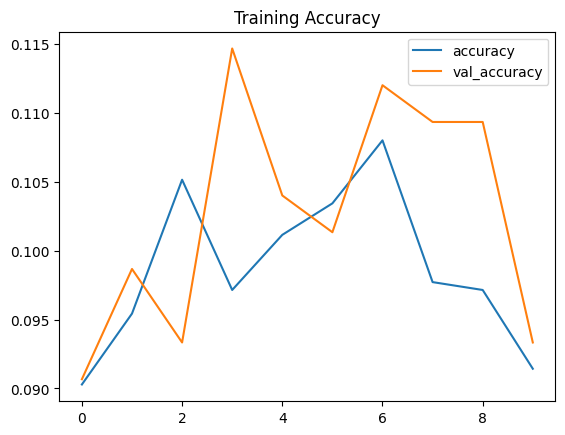

In [7]:
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

# 1. データのロード
dataset_train, dataset_valid, dataset_test = tfds.load(
    'spoken_digit',
    split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
    shuffle_files=True
)

# 2. 前処理用パラメータ
NUM_DATA_POINTS = 1000
BATCH_SIZE = 32 # 8から少し増やして学習を安定させます

# 3. 前処理関数の修正（型変換と正規化を追加）
def preprocess_audio(el):
    audio = el['audio']
    # 形状の調整とパディング/クリッピング
    audio = tf.cond(
        tf.shape(audio)[0] > NUM_DATA_POINTS,
        true_fn=lambda: tf.slice(audio, begin=[0], size=[NUM_DATA_POINTS]),
        false_fn=lambda: tf.concat([audio, tf.zeros(NUM_DATA_POINTS - tf.shape(audio)[0], tf.int64)], axis=0)
    )

    # 【重要】float32にキャストし、正規化
    audio = tf.cast(audio, tf.float32)
    audio = audio / 32768.0  # 16bit音声を-1~1の範囲に正規化

    # 形状を(1000, 1)に確定
    audio = tf.reshape(audio, (NUM_DATA_POINTS, 1))

    # ラベルはスカラー値として返す
    label = el['label']
    return audio, label

# 4. データセットの構築
dataset_prep_train = dataset_train.map(preprocess_audio).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
dataset_prep_valid = dataset_valid.map(preprocess_audio).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 5. 双方向LSTMモデルの定義
tf.keras.backend.clear_session()

model_4 = tf.keras.models.Sequential([
    layers.Input((NUM_DATA_POINTS, 1)),
    layers.Bidirectional(layers.LSTM(64)), # 順方向と逆方向の両方から学習
    layers.Dense(10, activation='softmax')
])

model_4.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5),
    metrics=['accuracy']
)

model_4.summary()

# 6. 学習の実行
history = model_4.fit(
    dataset_prep_train,
    validation_data=dataset_prep_valid,
    epochs=10 # 1エポックだと学習が進まないため10程度に設定
)

# 7. 学習結果の可視化
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.show()

#フレームワーク演習）Seq2Seq

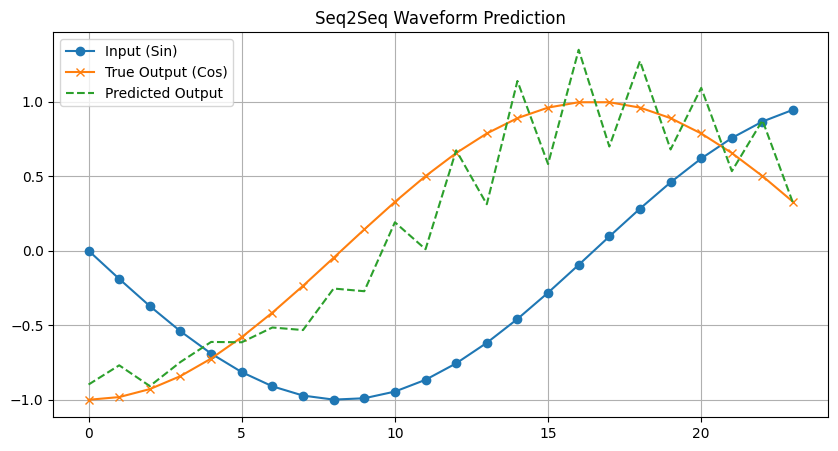

In [8]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# 1. データの準備
x = np.linspace(-3 * np.pi, 3 * np.pi, 100)
seq_in = np.sin(x)
seq_out = np.cos(x)

NUM_ENC_TOKENS = 1
NUM_DEC_TOKENS = 1
NUM_HIDDEN_PARAMS = 10
NUM_STEPS = 24

# 2. 学習用モデルの定義
tf.keras.backend.clear_session()

# Encoder
e_input = tf.keras.layers.Input(shape=(NUM_STEPS, NUM_ENC_TOKENS), name='e_input')
_, e_state = tf.keras.layers.SimpleRNN(NUM_HIDDEN_PARAMS, return_state=True, name='e_rnn')(e_input)

# Decoder
d_input = tf.keras.layers.Input(shape=(NUM_STEPS, NUM_DEC_TOKENS), name='d_input')
d_rnn = tf.keras.layers.SimpleRNN(NUM_HIDDEN_PARAMS, return_sequences=True, return_state=True, name='d_rnn')
d_rnn_out, _ = d_rnn(d_input, initial_state=e_state) # SimpleRNNのstateは1つなのでリスト不要

d_dense = tf.keras.layers.Dense(NUM_DEC_TOKENS, activation='linear', name='d_output')
d_output = d_dense(d_rnn_out)

model_train = tf.keras.models.Model(inputs=[e_input, d_input], outputs=d_output)
model_train.compile(optimizer='adam', loss='mean_squared_error')

# 3. データの整形
n = len(x) - NUM_STEPS
ex = np.zeros((n, NUM_STEPS, 1))
dx = np.zeros((n, NUM_STEPS, 1))
dy = np.zeros((n, NUM_STEPS, 1))

for i in range(n):
    ex[i, :, 0] = seq_in[i:i + NUM_STEPS]
    dx[i, 1:, 0] = seq_out[i:i + NUM_STEPS - 1] # 1ステップずらしたTeacher Forcing用データ
    dy[i, :, 0] = seq_out[i:i + NUM_STEPS]

# 4. 学習
BATCH_SIZE = 16
EPOCHS = 80
model_train.fit([ex, dx], dy, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=0.2, verbose=0)

# --- ここから加筆：推論用モデルの作成 ---

# Encoder推論モデル: 入力波形からコンテキスト（e_state）を抽出
model_encoder = tf.keras.models.Model(inputs=e_input, outputs=e_state)

# Decoder推論モデル: コンテキストと前の時刻の出力を受け取り、次の値を予測
d_infer_state_input = tf.keras.layers.Input(shape=(NUM_HIDDEN_PARAMS,))
d_infer_input = tf.keras.layers.Input(shape=(1, NUM_DEC_TOKENS)) # 1ステップずつ予測

d_infer_rnn_out, d_infer_state = d_rnn(d_infer_input, initial_state=d_infer_state_input)
d_infer_output = d_dense(d_infer_rnn_out)

model_decoder = tf.keras.models.Model(
    inputs=[d_infer_input, d_infer_state_input],
    outputs=[d_infer_output, d_infer_state]
)

# 5. 予測（推論）の実行
def predict_seq2seq(input_data):
    state = model_encoder.predict(input_data, verbose=0)
    target_seq = np.zeros((1, 1, NUM_DEC_TOKENS)) # 最初の入力（0など）

    decoded_seq = []
    for _ in range(NUM_STEPS):
        output, state = model_decoder.predict([target_seq, state], verbose=0)
        decoded_seq.append(output[0, 0, 0])
        target_seq = output # 予測値を次のステップの入力にする

    return np.array(decoded_seq)

# テストデータで確認
test_idx = 0
sample_input = ex[test_idx:test_idx+1]
predicted = predict_seq2seq(sample_input)

# 6. 結果のプロット
plt.figure(figsize=(10, 5))
plt.plot(range(NUM_STEPS), ex[test_idx].flatten(), label="Input (Sin)", marker='o')
plt.plot(range(NUM_STEPS), dy[test_idx].flatten(), label="True Output (Cos)", marker='x')
plt.plot(range(NUM_STEPS), predicted, label="Predicted Output", linestyle='--')
plt.title("Seq2Seq Waveform Prediction")
plt.legend()
plt.grid()
plt.show()

推論用モデルの準備〜推論

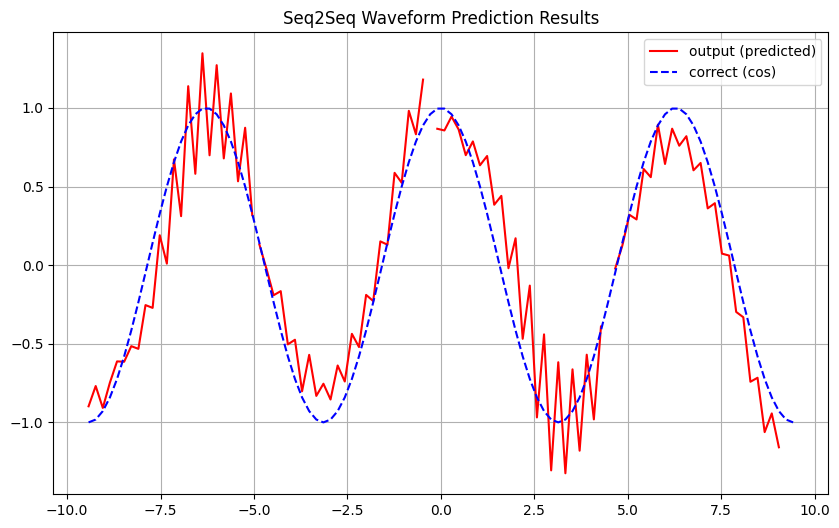

In [9]:
# 1. 推論用モデルの構築（Encoder）
# 入力波形からコンテキスト（隠れ状態）を取り出す
model_pred_e = tf.keras.models.Model(inputs=[e_input], outputs=[e_state])

# 2. 推論用モデルの構築（Decoder）
# 1ステップ分の入力と、前の時刻の隠れ状態を受け取る
pred_d_input = tf.keras.layers.Input(shape=(1, 1))

pred_d_state_in = tf.keras.layers.Input(shape=(NUM_HIDDEN_PARAMS,))

# SimpleRNNの場合、initial_stateはリスト[ ]に入れずに渡します
pred_d_output, pred_d_state = d_rnn(pred_d_input, initial_state=pred_d_state_in)
pred_d_output = d_dense(pred_d_output)

pred_d_model = tf.keras.Model(inputs=[pred_d_input, pred_d_state_in], outputs=[pred_d_output, pred_d_state])

# 3. 推論実行関数の定義
def predict(input_data):
    # Encoderで最初の状態を取得
    state_value = model_pred_e.predict(input_data, verbose=0)
    # Decoderへの最初の入力（0から開始）
    _dy = np.zeros((1, 1, 1))

    output_data = []
    for i in range(0, NUM_STEPS):
        # 1ステップ先を予測し、同時に隠れ状態を更新する
        y_output, state_value = pred_d_model.predict([_dy, state_value], verbose=0)

        output_data.append(y_output[0, 0, 0])
        # 【重要】予測した結果を次のステップの入力にする
        _dy[0, 0, 0] = y_output[0, 0, 0]

    return output_data

# 4. 推論の実行と可視化
plt.figure(figsize=(10, 6))
init_points = [0, 24, 49, 74]

for i in init_points:
    _x = ex[i : i + 1]
    _y = predict(_x)

    # 予測開始位置を考慮してプロット
    # 推論は入力xの「NUM_STEPS分」の後に行われるため、インデックスを調整
    target_x = x[i : i + NUM_STEPS]

    if i == 0:
        plt.plot(target_x, _y, color="red", label='output (predicted)')
    else:
        plt.plot(target_x, _y, color="red")

# 正解データのプロット
plt.plot(x, seq_out, color='blue', linestyle="dashed", label='correct (cos)')
plt.title("Seq2Seq Waveform Prediction Results")
plt.grid()
plt.legend()
plt.show()

#フレームワーク演習）data-augmentation

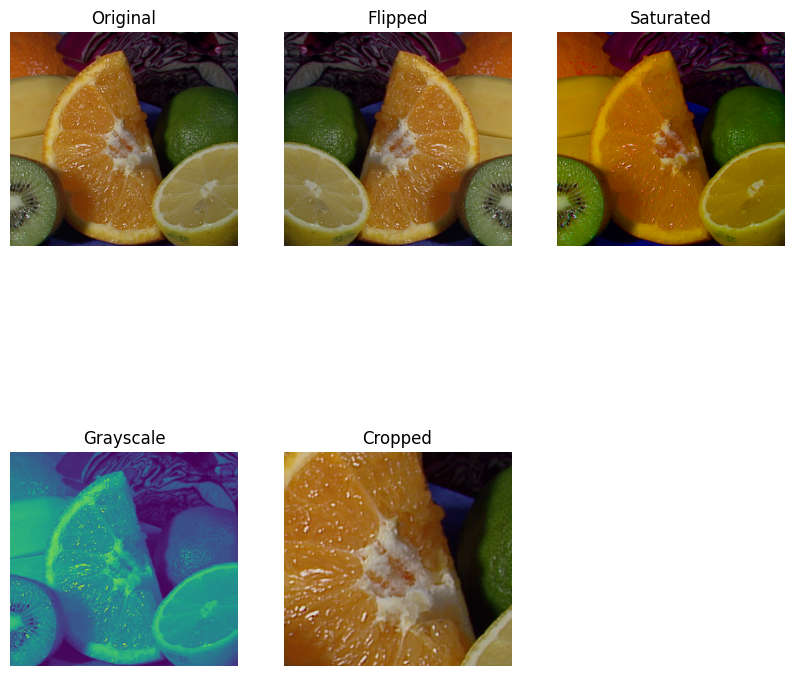

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

def show_images(images, titles=None):
    """
    複数の画像を表示する。
    images: 画像のリスト
    titles: 各画像につけるタイトルのリスト
    """
    n_images = len(images)
    # 表示するグリッドのサイズを計算
    cols = int(np.ceil(np.sqrt(n_images)))
    rows = int(np.ceil(n_images / cols))

    plt.figure(figsize=(10, 10))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i + 1)
        # floatに変換されている場合を考慮してclip
        img_to_show = np.clip(image, 0, 255).astype(np.uint8)
        plt.imshow(img_to_show)
        if titles:
            plt.title(titles[i])
        plt.axis('off')
    plt.show()

# 画像のダウンロード
!mkdir -p sample_data
!wget -qnc --no-check-certificate -O ./sample_data/image_origin.jpg \
https://github.com/opencv/opencv/raw/master/samples/data/fruits.jpg

# 画像の読み込みとデコード
contents = tf.io.read_file("./sample_data/image_origin.jpg")
image_origin = tf.image.decode_jpeg(contents, channels=3)

# 演習：さまざまな画像処理
# 1. 左右反転
flipped = tf.image.flip_left_right(image_origin)
# 2. 彩度の変更
saturated = tf.image.adjust_saturation(image_origin, 3)
# 3. グレースケール化
gray = tf.image.rgb_to_grayscale(image_origin)
# 4. 中央クロップ（リサイズ）
cropped = tf.image.central_crop(image_origin, central_fraction=0.5)

# 結果の表示
images_to_show = [
    image_origin.numpy(),
    flipped.numpy(),
    saturated.numpy(),
    gray.numpy(),
    cropped.numpy()
]
titles = ["Original", "Flipped", "Saturated", "Grayscale", "Cropped"]

show_images(images_to_show, titles)